**Problem definition:**\
The Drop off ridesharing problem is researched. The problem is formulated into a mathematical model with decision variables, an objective functions and constrains. The simulated annealing (SA) algorithm is implemented to solve this problem. An experiment with the real world data sets is done to test the performance of this algorithm. 
It is required to generate an optimal schedule for each dropoff to serve the passengers of Toronto in such a way that optimizes at least two of the following criteria, preferably all:

• Minimizing the total number of SAVs required.\
• Minimizing the total travel distance/time of SAVs’ trips.\
• Minimizing the total travel time of passengers’ trips.\
• Maximizing the number of matched (served) requests.\
• Minimizing the cost for the SAVs’ trips/loss during uncharged driving\
• Maximizing the SAV's earning/total profit.\
• Minimizing the cost for the passengers’ trips.\
• Minimizing passenger’s waiting time.\
• Balancing the routes of SAV load.\

In [1]:
import pandas as pd
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import osmnx as ox
from utilities import *

In [2]:
# You can use different excel data
#file_path = './data/Maven_stations_saved.csv'
file_path = './data/Dropoff_locations.csv'
df = pd.read_csv(file_path)
numberOfStops = len(df)
df

,Longitude,Latitude,Address
0,-79.389653,43.669624,Bay Station
1,-79.379568,43.768544,Bessarion Station
2,-79.368367,43.673658,Castle Frank Station
3,-79.418020,43.663659,Christie Station
4,-79.323692,43.683357,Coxwell Station
5,-79.346952,43.775110,Don Mills Station
6,-79.462910,43.750348,Downsview Station
7,-79.380984,43.656363,Dundas Station
8,-79.407034,43.674731,Dupont Station
9,-79.415660,43.780174,Finch Station


In [3]:
# store the values into a numpy array
addresses  = df.iloc[:, 2].values

In [4]:
POIS = []
for address in addresses:
    POIS.append(poi(address,"canada"))
POIS

[Name: Bay ID: 25991314,
 Name: Bessarion ID: 5318484724,
 Name: Castle Frank Station ID: 432581398,
 Name: Christie ID: 5262888213,
 Name: Coxwell Station ID: 7100591226,
 Name: Don Mills Station ID: 1246332677,
 Name: Sheppard West ID: 420561530,
 Name: Dundas ID: 249641649,
 Name: Dupont ID: 5320349317,
 Name: (Finch Station) ID: 582990836,
 Name: Eglinton West Station ID: 6592347255,
 Name: Kennedy Station ID: 5593394546,
 Name: Donlands ID: 55639063,
 Name: Kipling Station ID: 4597249809,
 Name: High Park Station ID: 2883464892,
 Name: Eglinton Station ID: 2266180445]

In [5]:
drawPOIS(POIS, zoom=10)

Map(center=[43.67628716875, -79.43114413142783], close_popup_on_click=False, controls=(ZoomControl(options=['p…

In [6]:
G = nx.DiGraph()
G.add_nodes_from(POIS)

In [7]:
# this will take 1-2 minutes because you need to find
# two routes between each pair of POIs
durations = []
for source in G.nodes():
    duration = []
    for destination in G.nodes():
        if source == destination: 
            duration.append(0)
            continue
        G.add_edge(source, destination, route = source.route_to(destination))
        route = source.route_to(destination)
        duration.append(route['duration'])
    durations.append(duration)

In [8]:
durations = np.array(durations)
durations

array([[   0. , 1243.5,  238.3,  306.9,  697.6, 1183.9, 1199.4, 3762. ,
         239.3, 1514.5,  730.3, 1347.5,  552.2, 1265.2,  765.1,  544.4],
       [1237.4,    0. ,  999.3, 1293.3, 1112.4,  281.2,  689.8, 4108.7,
        1250. ,  554.5,  747.6,  952.5, 1023.1, 1624. , 1310.6,  890.1],
       [ 238.1, 1095.6,    0. ,  501.8,  459.3,  945.6, 1355.9, 3820.5,
         397.2, 1522.1,  886.8, 1109.2,  313.9, 1323.7,  960. ,  656.6],
       [ 334.6, 1212.7,  529.7,    0. ,  989. , 1467.6, 1031.3, 3719. ,
         225.6, 1545.8,  562.2, 1638.9,  843.6, 1121.7,  497. ,  723. ],
       [ 697.4, 1076.9,  459.3,  961.1,    0. ,  926.9, 1575.4, 4021.6,
         856.5, 1503.4, 1223.3,  884.7,  170.8, 1524.8, 1275.2, 1049.5],
       [1264.2,  249.7, 1026.1, 1435.9, 1139.2,    0. ,  882.1, 4251.3,
        1392.6,  768. ,  890.2,  936. , 1049.9, 1766.6, 1453.2, 1032.7],
       [1211.8,  677. , 1370.8, 1063.1, 1617.1,  949.1,    0. , 3953.2,
        1019.8,  835.9,  517.4, 1457.2, 1527.8, 1468.5, 11

In [9]:
# Define a function to compute the cost of the solution
# It gets you the sum for the solution
def cost(m, sol):
    M = np.zeros(numberOfStops-1)
    for i in range(numberOfStops-1):
        M[i] = m[sol[i]-1,sol[i+1]-1]
    fitness = np.sum(M)
    return fitness

In [10]:
# parameters
iteration = 200000   # number of iterations
temp = 5   # initial temperature

In [11]:
# create an array to store all individuals
sol_hist = np.zeros([iteration+1,numberOfStops])

# create an array to store all fitness values corresponding to the individual
fitness_hist = np.zeros(iteration+1)

# initialize the fitness array
for i in range(iteration+1):
    fitness_hist[i] = 99999

In [12]:
# generate the initial solution
initial_sol = np.arange(1,numberOfStops+1)
random.shuffle(initial_sol)
initial_sol = initial_sol.astype(int)

In [13]:
# compute the fitness of the initial solution
sol_hist[0] = initial_sol
fitness_hist[0] = cost(durations, initial_sol)

In [14]:
running_time = np.zeros(iteration)
best_outputs = []
# implementation of simulated annealing
# implementation of simulated annealing
for i in range(1,iteration+1):

    # record the starting time
    start_time = time.time()

    # generate new solution
    a = random.randint(0,numberOfStops-1)
    b = random.randint(0,numberOfStops-1)
    sol_hist[i] = sol_hist[i-1]
    sol_hist[i,a] = sol_hist[i-1,b]
    sol_hist[i,b] = sol_hist[i-1,a]
    sol = sol_hist[i]
    sol = sol.astype(int)

    # compute the fitness of the new solution
    fitness_hist[i] = cost(durations, sol)

    if fitness_hist[i] > fitness_hist[i-1]:
        prob = math.exp(-(abs(fitness_hist[i]-fitness_hist[i-1]))/temp)
        r = np.random.random()
        if r > prob:
            sol_hist[i] = sol_hist[i-1]

    # update the annealing temperature
    temp = temp*0.999

    # record the best output for every iteration
    best_outputs.append(np.min(fitness_hist))

    # compute and store the running time
    running_time[i-1] = time.time() - start_time


In [15]:
# return the index of the solution corresponding to the best fitness
best_index = np.where(fitness_hist == np.min(fitness_hist))

running_time = running_time.cumsum()

# to get the index of iteration when the fitness reaches its minimum value (convergence point of the algorithm)
convergence_index = np.where(best_outputs == np.min(best_outputs))
convergence_time = running_time[convergence_index]

print("The best solution is:", sol_hist[best_index].astype(int))
print('The best fitness value is:', fitness_hist[best_index])
print("The algorithm converges in", np.min(convergence_index), "iterations.")
print("The algorithm converges in", np.min(convergence_time), "seconds.")


The best solution is: [[ 8 14 15  9  1  3  4  6 10  2  7 11 16 13  5 12]]
The best fitness value is: [11913.6]
The algorithm converges in 78760 iterations.
The algorithm converges in 8.270669221878052 seconds.


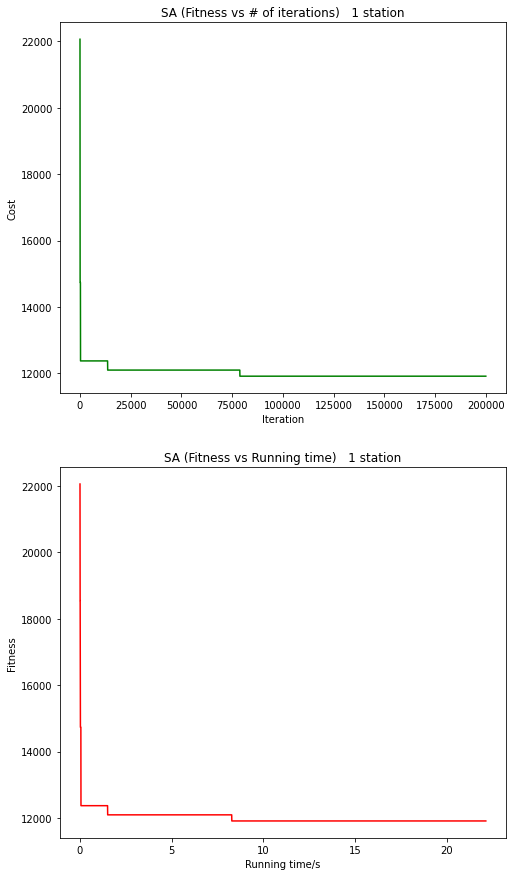

In [16]:
fig, ax = plt.subplots(2, figsize = (8,15))
ax[0].plot(best_outputs, 'green')
ax[0].set_xlabel("Iteration", fontsize = 10)
ax[0].set_ylabel("Cost", fontsize = 10)
ax[0].set_title("SA (Fitness vs # of iterations)   1 station", fontsize = 12)

ax[1].plot(running_time, best_outputs, 'red')
ax[1].set_xlabel("Running time/s", fontsize = 10)
ax[1].set_ylabel("Fitness", fontsize = 10)
ax[1].set_title("SA (Fitness vs Running time)   1 station", fontsize = 12)
plt.show()

In [17]:
#Visualization
optimalRoute = sol_hist[best_index].astype(int)-1
optimalRoute = optimalRoute[0]
optimalRoute
currentRoute = G[POIS[optimalRoute[0]]][POIS[optimalRoute[1]]]['route']['coords']
for i in range(1,len(optimalRoute)-1):
    currentRoute += G[POIS[optimalRoute[i]]][POIS[optimalRoute[i+1]]]['route']['coords']
drawRoute(currentRoute)

Map(center=[43.775686, -79.344626], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…